In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

DATAPATH = '/content/AMZN.csv'

Tempdata = pd.read_csv(DATAPATH,
                       )
#Tempdata.head()
Tempdata.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1232,2018-11-21,1542.989990,1550.000000,1515.000000,1516.729980,1516.729980,5716800
1233,2018-11-23,1517.000000,1536.199951,1501.810059,1502.060059,1502.060059,2707600
1234,2018-11-26,1539.000000,1584.810059,1524.219971,1581.329956,1581.329956,6257700
1235,2018-11-27,1575.989990,1597.650024,1558.010010,1581.420044,1581.420044,5783200
1236,2018-11-28,1613.920044,1681.449951,1601.219971,1677.750000,1677.750000,8437700


In [ ]:
data = Tempdata.dropna()


data.index = pd.to_datetime(data.Date)
  
data = data["Close"]['2014-01-01':'2018-11-28']
data.describe()

count    1237.000000
mean      810.560688
std       470.605697
min       286.950012
25%       389.799988
50%       717.929993
75%       994.619995
max      2039.510010
Name: Close, dtype: float64

In [ ]:
data

Date
2014-01-02     397.970001
2014-01-03     396.440002
2014-01-06     393.630005
2014-01-07     398.029999
2014-01-08     401.920013
                 ...     
2018-11-21    1516.729980
2018-11-23    1502.060059
2018-11-26    1581.329956
2018-11-27    1581.420044
2018-11-28    1677.750000
Name: Close, Length: 1237, dtype: float64

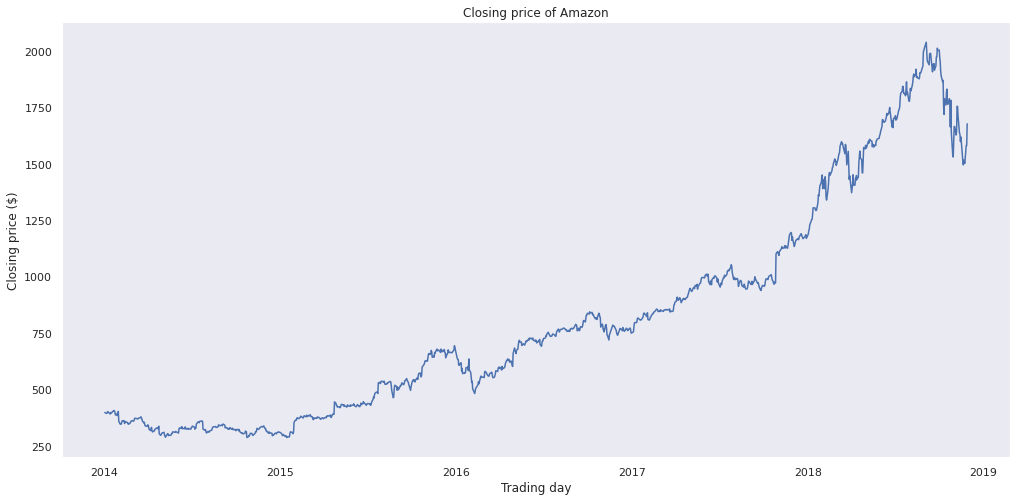

In [ ]:
plt.figure(figsize=(17, 8))
plt.plot(data)
plt.title('Closing price of Amazon')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 86.5 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


11.844011994805197
36.39900019409003
77.20415230838904


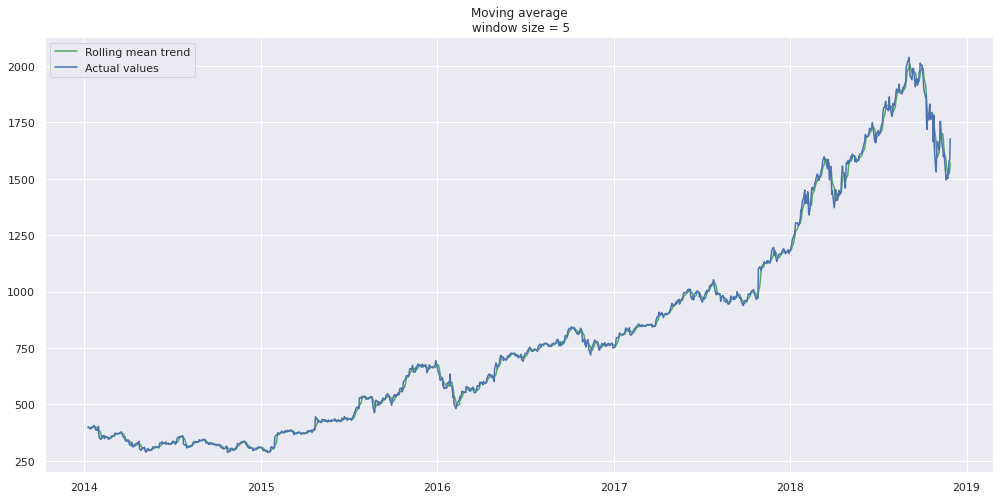

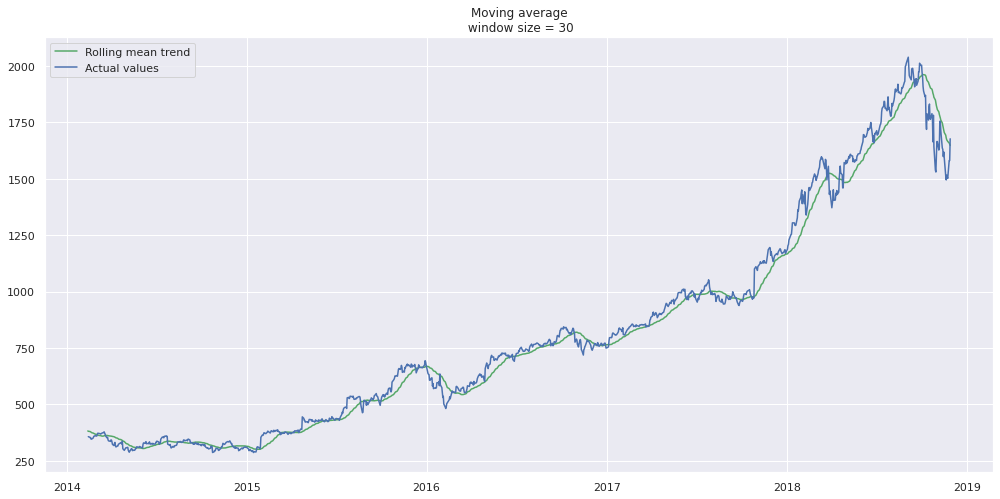

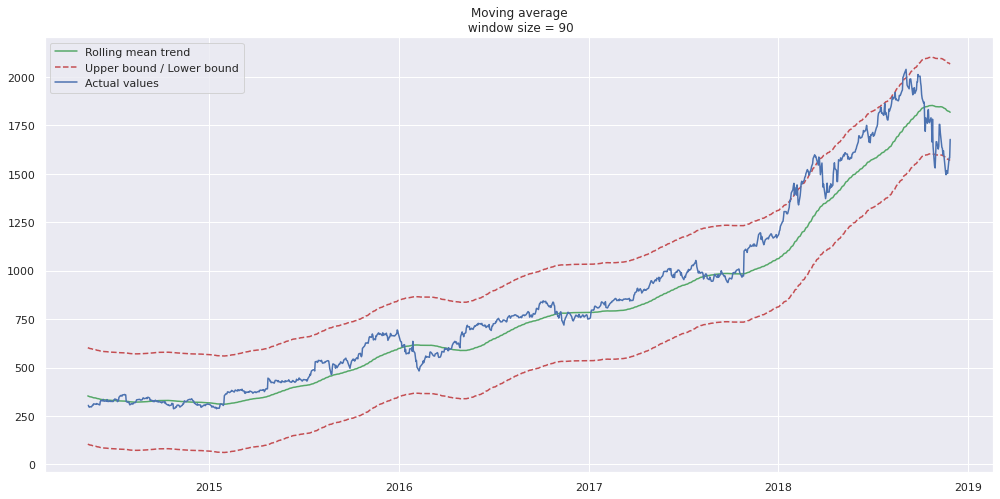

In [ ]:
# Applying Model Average Model 
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean()
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    mae = mean_absolute_error(series[window:], rolling_mean[window:])
    print(mae)

    if (plot_intervals) :
         deviation = np.std(series[window:] - rolling_mean[window:])
         lower_bound = rolling_mean - (mae + scale * deviation)
         upper_bound = rolling_mean + (mae + scale * deviation)
         plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
         plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

#Smooth by the previous 5 days (by week)
plot_moving_average(data, 5)

#Smooth by the previous month (30 days)
plot_moving_average(data, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(data, 90, plot_intervals=True)      
  

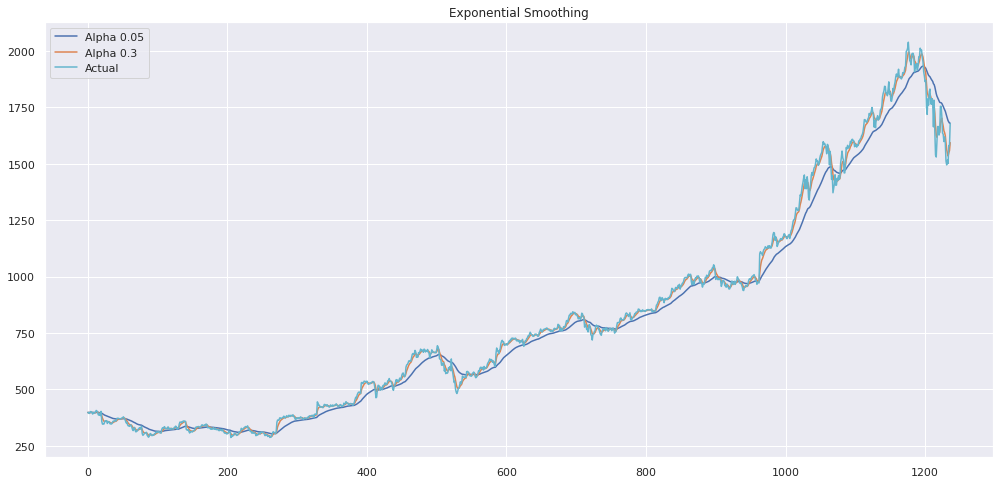

In [ ]:
# Exponential Smoothing
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(data, [0.05, 0.3])
    
 

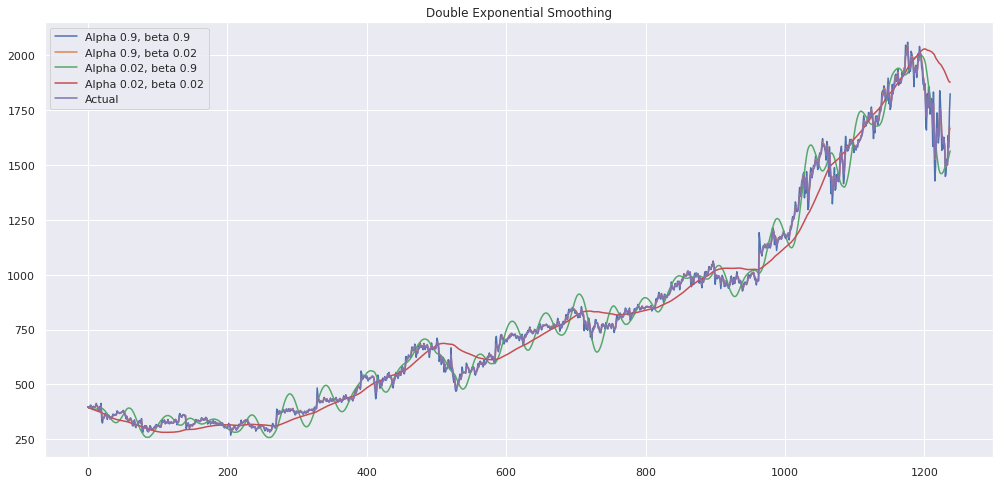

In [ ]:
#DOUBLE EXPONENTIAL SMOOTHING
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(data, alphas=[0.9, 0.02], betas=[0.9, 0.02])

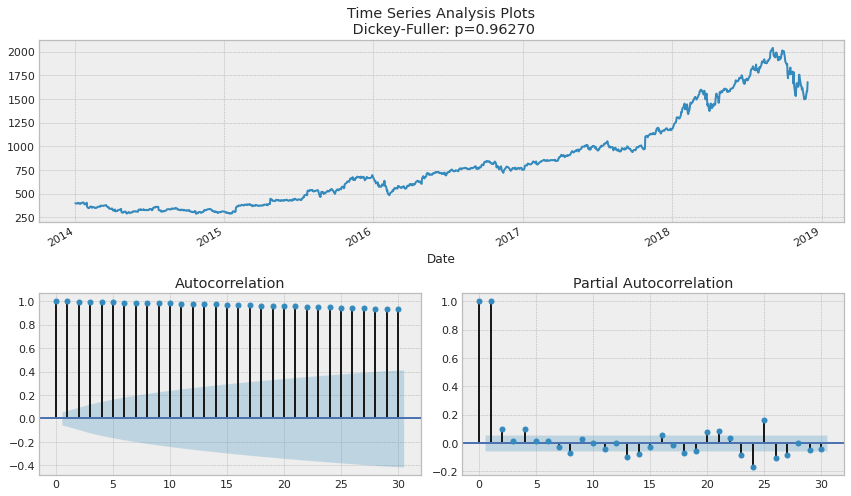

In [ ]:
#Modelling
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data, lags=30)



In [ ]:
# Take the first difference to remove to make the process stationary
#data_diff = data.Close - data.Close.shift(1)
#data['Close_diff']  = data  - data.shift(1)

#tsplot(data['Close_diff'][1:], lags=30)
#data=data.dropna()


In [ ]:
data

Date
2014-01-02     397.970001
2014-01-03     396.440002
2014-01-06     393.630005
2014-01-07     398.029999
2014-01-08     401.920013
                 ...     
2018-11-21    1516.729980
2018-11-23    1502.060059
2018-11-26    1581.329956
2018-11-27    1581.420044
2018-11-28    1677.750000
Name: Close, Length: 1237, dtype: float64

In [ ]:
from pmdarima.arima.utils import ndiffs
ndiffs(data,test='adf')
# used to find the value of d

1

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

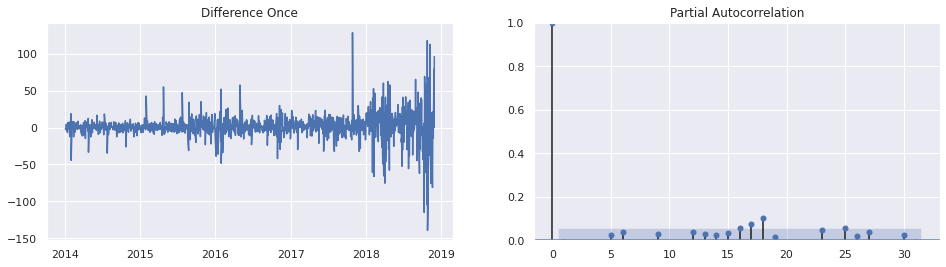

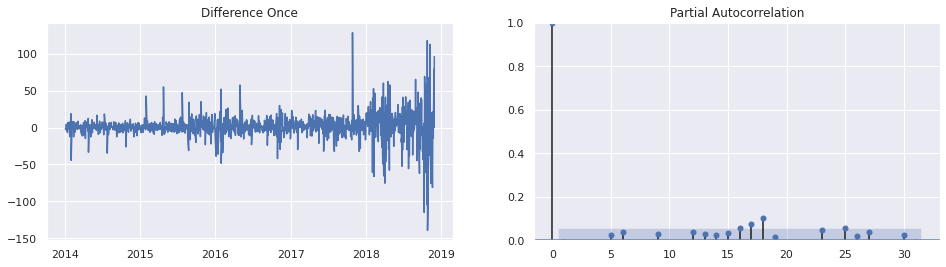

In [ ]:
diff=data.diff().dropna()
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference Once")
ax2.set_ylim(0,1)
plot_pacf(diff,ax=ax2)
#p=16

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

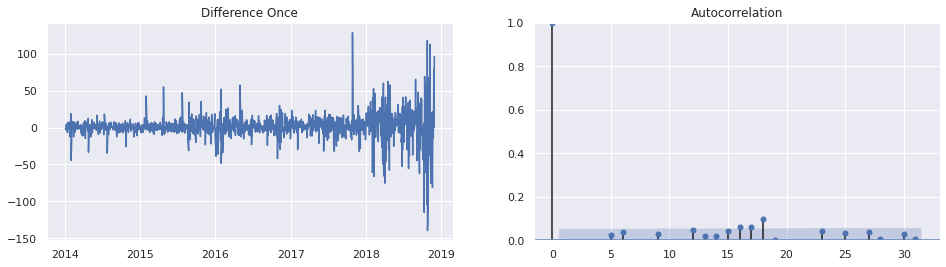

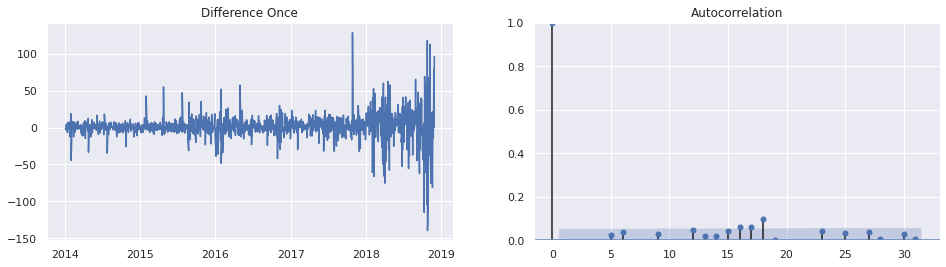

In [ ]:
diff=data.diff().dropna()
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference Once")
ax2.set_ylim(0,1)
plot_acf(diff,ax=ax2)
# q=16

In [ ]:
n =int(len(data)*0.954)
train=data[:n].values
test=data[n:].values
print(len(train))
print(len(test))
print(test)

1180
57
[1939.01001  1987.150024 1990.       1989.869995 1970.189941 1908.030029
 1941.050049 1926.420044 1944.300049 1915.01001  1934.359985 1974.550049
 1974.849976 2012.97998  2003.       2004.359985 1971.310059 1952.76001
 1909.420044 1889.650024 1864.420044 1870.319946 1755.25     1719.359985
 1788.609985 1760.949951 1819.959961 1831.72998  1770.719971 1764.030029
 1789.300049 1768.699951 1664.199951 1782.170044 1642.810059 1538.880005
 1530.420044 1598.01001  1665.530029 1665.530029 1627.800049 1642.810059
 1755.48999  1754.910034 1712.430054 1636.849976 1631.170044 1599.01001
 1619.439941 1593.410034 1512.290039 1495.459961 1516.72998  1502.060059
 1581.329956 1581.420044 1677.75    ]


In [ ]:
import statsmodels.api as smapi

model = smapi.tsa.arima.ARIMA(train,order=(16,1,12))

fitted = model.fit()

print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1180
Model:               ARIMA(16, 1, 12)   Log Likelihood               -4754.852
Date:                Wed, 25 Jan 2023   AIC                           9567.703
Time:                        03:24:00   BIC                           9714.804
Sample:                             0   HQIC                          9623.163
                               - 1180                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1784      0.888      0.201      0.841      -1.561       1.918
ar.L2          0.6421      0.510      1.258      0.208      -0.358       1.642
ar.L3          0.0264      0.630      0.042      0.9

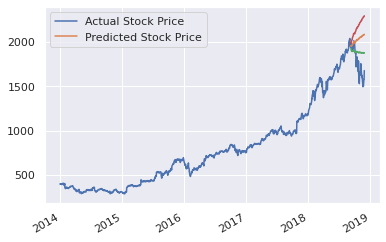

In [ ]:
import statsmodels.api as sm
import pandas_datareader.data as web
import matplotlib.pyplot as plt

df=data

total = len(data)
aaa = 57
hist = total - aaa

#model = sm.tsa.statespace.SARIMAX(data.values[:hist], trend='c', order=(16,1,12))
#fitted = model.fit(disp=False)

result = fitted.forecast(aaa, alpha = 0.1)
conf_ins = fitted.get_forecast(aaa).summary_frame()
ind = np.arange(total)

fig, ax = plt.subplots()
ax.plot(data.index, data.values, label='Actual Stock Price')
ax.plot(data.index[hist:], result, label='Predicted Stock Price')
ax.plot(data.index[hist:], conf_ins['mean_ci_lower'])
ax.plot(data.index[hist:], conf_ins['mean_ci_upper'])
ax.legend()
fig.autofmt_xdate()
plt.show()

In [ ]:
print(data.index[hist:])
print(result)

DatetimeIndex(['2018-09-10', '2018-09-11', '2018-09-12', '2018-09-13',
               '2018-09-14', '2018-09-17', '2018-09-18', '2018-09-19',
               '2018-09-20', '2018-09-21', '2018-09-24', '2018-09-25',
               '2018-09-26', '2018-09-27', '2018-09-28', '2018-10-01',
               '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05',
               '2018-10-08', '2018-10-09', '2018-10-10', '2018-10-11',
               '2018-10-12', '2018-10-15', '2018-10-16', '2018-10-17',
               '2018-10-18', '2018-10-19', '2018-10-22', '2018-10-23',
               '2018-10-24', '2018-10-25', '2018-10-26', '2018-10-29',
               '2018-10-30', '2018-10-31', '2018-11-01', '2018-11-02',
               '2018-11-05', '2018-11-06', '2018-11-07', '2018-11-08',
               '2018-11-09', '2018-11-12', '2018-11-13', '2018-11-14',
               '2018-11-15', '2018-11-16', '2018-11-19', '2018-11-20',
               '2018-11-21', '2018-11-23', '2018-11-26', '2018-11-27',
      

In [ ]:
print(data.index)

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2018-11-14', '2018-11-15', '2018-11-16', '2018-11-19',
               '2018-11-20', '2018-11-21', '2018-11-23', '2018-11-26',
               '2018-11-27', '2018-11-28'],
              dtype='datetime64[ns]', name='Date', length=1237, freq=None)


In [ ]:
print(data.loc['2018-09-10':'2018-11-28'])
print(data.loc['2018-09-10':'2018-11-28'].describe())

Date
2018-09-10    1939.010010
2018-09-11    1987.150024
2018-09-12    1990.000000
2018-09-13    1989.869995
2018-09-14    1970.189941
2018-09-17    1908.030029
2018-09-18    1941.050049
2018-09-19    1926.420044
2018-09-20    1944.300049
2018-09-21    1915.010010
2018-09-24    1934.359985
2018-09-25    1974.550049
2018-09-26    1974.849976
2018-09-27    2012.979980
2018-09-28    2003.000000
2018-10-01    2004.359985
2018-10-02    1971.310059
2018-10-03    1952.760010
2018-10-04    1909.420044
2018-10-05    1889.650024
2018-10-08    1864.420044
2018-10-09    1870.319946
2018-10-10    1755.250000
2018-10-11    1719.359985
2018-10-12    1788.609985
2018-10-15    1760.949951
2018-10-16    1819.959961
2018-10-17    1831.729980
2018-10-18    1770.719971
2018-10-19    1764.030029
2018-10-22    1789.300049
2018-10-23    1768.699951
2018-10-24    1664.199951
2018-10-25    1782.170044
2018-10-26    1642.810059
2018-10-29    1538.880005
2018-10-30    1530.420044
2018-10-31    1598.010010
2018-11

In [ ]:
print(data.index[hist:])

DatetimeIndex(['2018-09-10', '2018-09-11', '2018-09-12', '2018-09-13',
               '2018-09-14', '2018-09-17', '2018-09-18', '2018-09-19',
               '2018-09-20', '2018-09-21', '2018-09-24', '2018-09-25',
               '2018-09-26', '2018-09-27', '2018-09-28', '2018-10-01',
               '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05',
               '2018-10-08', '2018-10-09', '2018-10-10', '2018-10-11',
               '2018-10-12', '2018-10-15', '2018-10-16', '2018-10-17',
               '2018-10-18', '2018-10-19', '2018-10-22', '2018-10-23',
               '2018-10-24', '2018-10-25', '2018-10-26', '2018-10-29',
               '2018-10-30', '2018-10-31', '2018-11-01', '2018-11-02',
               '2018-11-05', '2018-11-06', '2018-11-07', '2018-11-08',
               '2018-11-09', '2018-11-12', '2018-11-13', '2018-11-14',
               '2018-11-15', '2018-11-16', '2018-11-19', '2018-11-20',
               '2018-11-21', '2018-11-23', '2018-11-26', '2018-11-27',
      

In [ ]:
res=mean_squared_error(result,data.loc['2018-09-10':'2018-11-28'])
print(res)

99628.25770861749


In [ ]:
import math
rmse = math.sqrt(res)
print('RMSE: '+str(rmse))

RMSE: 315.6394425743042


In [ ]:
# Finally we have predicted the values for the year 2018 and the actual and predicted values are pretty close to each other 